In [9]:
import numpy as np
import librosa, os, keras, time
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.utils import make_chunks
from collections import deque

In [10]:
dir1 = './Instrument-Classification/IRMAS-TestingData-Part1/Part1/'
dir2 = './Instrument-Classification/IRMAS-TestingData-Part2/Part2/'
dir3 = './Instrument-Classification/IRMAS-TestingData-Part3/Part3/'

model = keras.models.load_model('ICmodel_96_0.h5')

dir_array = [dir1,dir2,dir3]
instr = ['pia','gac','gel','vio','voi']
thr = [0.5, 0.5, 0.5 , 0.5, 0.5]
#instr = ['pia','gac']
#thr = [0.5,0.5]

auc = [[],[],[],[],[]]
truth = [[],[],[],[],[]]

#auc = [[],[]]
#truth = [[],[]]

In [11]:
def overlap(prediction):
    new_prediction = []
    for i in range(len(prediction)//2+1):
        y = []
        for j in range(0,len(instr)):
            y.append(0)
        new_prediction.append(y)
    
    for i in range(0,len(prediction),2):
        if (i==0):
            new_prediction[i//2] = 0.5*prediction[i] + 0.5*prediction[i+1]
        elif (i==len(prediction)-1):
            new_prediction[i//2] = 0.5*prediction[i] + 0.5*prediction[i-1]
        else:
            new_prediction[i//2] = 0.25*prediction[i-1] + 0.5*prediction[i] + 0.25*prediction[i+1]
    return new_prediction

def smooth(prediction):
    new_prediction = []
    for i in range(len(prediction)):
        y = []
        for j in range(0,len(instr)):
            y.append(0)
        new_prediction.append(y)
        
    for i in range(len(prediction)):
        for j in range(len(instr)):
            if i==0:
                if (prediction[i][j] < thr[j] and prediction[i+1][j] > thr[j]): new_prediction[i][j] = prediction[i+1][j]
                elif (prediction[i][j] > thr[j] and prediction[i+1][j] < thr[j]): new_prediction[i][j] = prediction[i+1][j]
                else: new_prediction[i][j] = prediction[i][j]
            elif i==len(prediction)-1:
                if (prediction[i][j] < thr[j] and prediction[i-1][j] > thr[j]): new_prediction[i][j] = prediction[i-1][j]
                elif (prediction[i][j] > thr[j] and prediction[i-1][j] < thr[j]): new_prediction[i][j] = prediction[i-1][j]
                else: new_prediction[i][j] = prediction[i][j]
            else:
                if (prediction[i][j]<thr[j] and prediction[i-1][j]>thr[j] and prediction[i+1][j]>thr[j]):
                    new_prediction[i][j] = (prediction[i-1][j]+prediction[i+1][j])/2
                elif (prediction[i][j]>thr[j] and prediction[i-1][j]<thr[j] and prediction[i+1][j]<thr[j]):
                    new_prediction[i][j] = (prediction[i-1][j]+prediction[i+1][j])/2
                else: new_prediction[i][j] = prediction[i][j]
    return new_prediction

In [12]:
def to_categorical(list_final):
    temp_list = [[0]*len(instr)]*(len(list_final))
    for i in range(len(list_final)):
        x = [0]*len(instr)
        x.insert(0,1)
        x.pop()
        for ins in instr:
            if (ins in list_final[i]): 
                temp_list[i] = [sum(x) for x in zip(temp_list[i],x)]
            x.insert(0,x.pop())
    return temp_list[0]

def prediction(predict):
    prediction = model.predict(predict)
    #over_prediction = overlap(prediction)
    #final_prediction = smooth(over_prediction)
    final_prediction = prediction
    
    sum = np.zeros(len(final_prediction[0]))
    for pred in final_prediction:
        for i in range(len(pred)):
            sum[i] = sum[i] + pred[i]
    sum[:] = [round(x/len(final_prediction),2) for x in sum]
    return sum

def average_accuracy(y_pred,y_label):
    acc = 0
    for i in range(len(y_pred)):
        acc = acc + abs(y_pred[i]-y_label[i])
    acc = acc / len(y_pred)
    return round(100*(1-acc),2)

def existance_accuracy(y_pred,y_label):
    acc = 0
    for i in range(len(y_pred)):
        if (y_pred[i]>=thr[i] and y_label[i]==1): acc+=1
        elif (y_pred[i]<thr[i] and y_label[i]==0): acc+=1
    acc = acc / len(y_pred)
    return round(100*(acc),2)

def lrap_accuracy(y_pred,y_label):
    z = instr.copy()
    y = y_pred.copy()
    y,z = (list(t) for t in zip(*sorted(zip(y,z))))
    
    chosen = []
    for i in range(len(instr)):
        if (y_label[i]==1):
            chosen.append(instr[i])
    
    sum = 0
    for i in range(len(instr)):
        num = 0
        den = 0
        if (y_label[i]==1):
            for j in range(len(instr)-1,-1,-1):
                den = den + 1
                if (z[j] in chosen): num = num + 1
                if (z[j] == instr[i]): break 
            sum = sum + num/den
    acc = sum / len(chosen)
    return [round(100*acc,2),sum,len(chosen)]

def auc_accuracy():
    final = []
    for i in range(len(instr)):
        x0 = 0
        y0 = 0
        pos = 0
        neg = 0
    
        for j in truth[i]:
            if (j==1): pos = pos + 1
            else: neg = neg + 1

        a,t = (list(x) for x in zip(*sorted(zip(auc[i],truth[i]))))
        points = [[x0,y0]]
    
        for j in range (len(t)-1,-1,-1):
            if (t[j]): y0 = y0 + 1/pos
            else: x0 = x0 + 1/neg
            points.append([x0,y0])
        final.append(points)
    return final

def predict_songs(start,end):
    sum_acc1 = 0
    sum_acc2 = 0
    sum_acc3 = 0
    len_acc3 = 0
    it = 1
    songs = 0
    start = 2*start
    end = 2*end - start
    text = True
    br = False
    unk_instr = False
    for dir in dir_array:
        for f in os.listdir(dir):
    
            if (start!=0):
                start = start -1
                continue
    
            if (unk_instr):
                unk_instr = False
                continue
        
            if (text):
                y_test = []
                x = open(dir+f)
                for line in x.readlines():
                    y_test.append(line[:3])
                    if (not (line[:3] in instr)): 
                        unk_instr = True
                        #print("Unknown instrument in: ",f)
                        #print("")
                if (unk_instr): 
                    continue
                y_label = to_categorical([y_test])
        
            if (not text):
                predict = []
                wav,sr = librosa.load(dir+f,mono=True,sr=22050)
                wav = wav / np.sqrt(np.mean(wav**2))
                chunks = []
                for i in range(2*(len(wav)//sr)-1):
                    chunks.append(wav[int((i/2)*sr):int((i+2)/2*sr)])
                for ch in chunks[:-1]:
                    #mel = librosa.feature.melspectrogram(ch,n_mels=96,fmax=11025,n_fft=1024,hop_length=256,power=1)
                    mel = librosa.core.cqt(ch,n_bins=96,bins_per_octave=12,hop_length=256)
                    mel = librosa.core.amplitude_to_db(np.abs(mel))
                    predict.append(mel)
                predict = np.expand_dims(np.array(predict),-1)
                y_pred = prediction(predict)
        
                acc1 = average_accuracy(y_pred,y_label)
                acc2 = existance_accuracy(y_pred,y_label)
                [acc3,sum,length] = lrap_accuracy(y_pred,y_label)
                
                #for auc evaluation
                for i in range(len(instr)):
                    auc[i].append(y_pred[i])
                    truth[i].append(y_label[i])
            
                sum_acc1 = sum_acc1 + acc1
                sum_acc2 = sum_acc2 + acc2
                sum_acc3 = sum_acc3 + sum
                len_acc3 = len_acc3 + length
                songs = songs + 1
                
                #print("Predicted track    : ",f)
                #print("Expected output    : ", y_label)
                #print("Predicted output   : ", y_pred)
                #print("Percentage Accuracy: ", acc1,"%")
                #print("Existance Accuracy : ", acc2,"%")
                #print("Lrap Accuracy      : ", acc3,"%")
                print("song")
            
            
            if (it == end):
                br = True
                break
            it = it + 1
            text = not text
        if (br): break
    
    auc_points = auc_accuracy()
    sum_acc3 = sum_acc3/len_acc3
    
    return [sum_acc1,sum_acc2,sum_acc3,auc_points,songs]

In [14]:
start = 1
end = 5000
[sum_acc1,sum_acc2,sum_acc3,auc_points,songs] = predict_songs(start,end)

aver_acc1 = round(sum_acc1/songs,2)
aver_acc2 = round(sum_acc2/songs,2)
aver_acc3 = round(100*sum_acc3,2)


print("------------------------------------------------------")
print("Average Percentage Accuracy among",songs,"songs: ",aver_acc1,"%")
print("Average Existance  Accuracy among",songs,"songs: ",aver_acc2,"%")
print("Average LRAP       Accuracy among",songs,"songs: ",aver_acc3,"%")

song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song


song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song
song


Area under the curve accuracy for  pia  is:  0.875
Area under the curve accuracy for  gac  is:  0.847
Area under the curve accuracy for  gel  is:  0.896
Area under the curve accuracy for  vio  is:  0.92
Area under the curve accuracy for  voi  is:  0.941


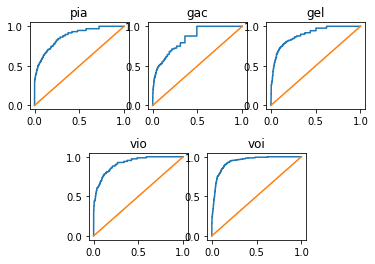

In [15]:
ax = [plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2),
      plt.subplot2grid((2,6), (0,2), colspan=2),
      plt.subplot2grid((2,6), (0,4), colspan=2),
      plt.subplot2grid((2,6), (1,1), colspan=2),
      plt.subplot2grid((2,6), (1,3), colspan=2)]

#i have no fucking idea how to enlarge the plots
a = np.linspace(0,1,100)
auc_acc = np.zeros(len(instr))
for i in range(len(instr)):
    ax[i].title.set_text(instr[i])
    ax[i].plot(*zip(*auc_points[i]))
    ax[i].plot(a,a)
    auc_acc[i] = 1-np.trapz(*zip(*auc_points[i]))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(len(instr)):
    print("Area under the curve accuracy for ",instr[i]," is: ",round(auc_acc[i],3))

In [ ]:
best = []
for i in range(len(auc_points)):
    max = 0
    for point in auc_points[i]:
        if (point[1]-point[0] > max):
            max = point[1]-point[0]
            x0 = point[0]
            y0 = point[1]
    print("Ideal threshold for ",instr[i]," is: ",round((1+y0-x0)/2,3))

In [8]:
max_fscore = np.zeros(len(instr))
max_thr = np.zeros(len(instr))

for i in range(len(instr)):
    for thr in np.arange(0,1.001,0.001):
        tp,fp,fn,tn = 0,0,0,0
        for j in range(len(auc[i])):
            if (auc[i][j] >= thr and truth[i][j]==1): tp = tp + 1
            if (auc[i][j] >= thr and truth[i][j]==0): fp = fp + 1
            if (auc[i][j] <  thr and truth[i][j]==1): fn = fn + 1
            if (auc[i][j] <  thr and truth[i][j]==0): tn = tn + 1
        if ((tp==0 and fp==0) or (tn==0 and fn==0)): continue
        precision = tp / (tp+fp)
        recall = tn / (tn+fn)
        fscore = 2*precision*recall/(precision+recall)
        if (fscore > max_fscore[i]): 
            max_fscore[i] = fscore
            max_thr[i] = thr
    print("Ideal threshold for",instr[i],"is",max_thr[i], "achieving fscore",round(max_fscore[i],2))

Ideal threshold for pia is 0.491 achieving fscore 0.66
Ideal threshold for gac is 0.491 achieving fscore 0.94
Ideal threshold for gel is 0.161 achieving fscore 0.95
Ideal threshold for vio is 0.0 achieving fscore 0.0
Ideal threshold for voi is 0.431 achieving fscore 0.93
